In [1]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import copy

Mounted at /content/drive


In [4]:
load_model = models.vgg19(weights="IMAGENET1K_V1")
print(load_model) # AdaptiveAvgPool2d((7,7))는 (7,7)이 되도록 알아서 pooling 해라 라는 뜻

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
load_model(torch.randn(2,3,224,224)).shape

torch.Size([2, 1000])

In [9]:
!pip install torchinfo
from torchinfo import summary
summary(load_model, input_size=(2,3,224,224), device='cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1000]                 --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [2, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [2, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [2, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [2, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [2, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [2, 256, 56, 56]          29

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224,224)), # size는 (height,width)
    # transforms.CenterCrop(size=(224,224)), # size 는 (height, width)
    ])

In [22]:
with open("/content/drive/MyDrive/Colab Notebooks/data/imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read()) # dictionary로 바꿀 수 있게 eval 사용해서 str -> dict 로
print(idx2label)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [23]:
idx2label[150]

'sea lion'

<class 'numpy.ndarray'>
(683, 1024, 3)
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


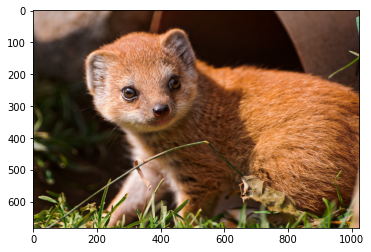

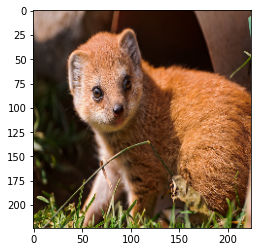

In [30]:
X=plt.imread("/content/drive/MyDrive/Colab Notebooks/data/my_image/1.jpg")
print(type(X))
print(X.shape)
plt.imshow(X)

X=transform(X)
print(type(X))
print(X.shape)
plt.figure()
plt.imshow(X.permute(1,2,0))

X = X.unsqueeze(dim=0)
print(X.shape)

In [38]:
load_model.eval()
with torch.no_grad():
    y_hat_sorted = load_model(X).sort(descending=True)
    # print(y_hat_sorted)
    percent_top5 = F.softmax(y_hat_sorted[0], dim=1)[0,:5]*100
    # print(percent_top5)
    pred_top5 = y_hat_sorted[1][0,:5] # sort 하고나서 [1]에 index가 담겨있음
    # print(pred_top5)
for i, idx in enumerate(pred_top5):
    print(idx2label[idx.item()],end="")
    print(f" ({round(percent_top5[i].item(),1)} %)")

mongoose (40.3 %)
weasel (33.2 %)
mink (16.2 %)
polecat, fitch, foulmart, foumart, Mustela putorius (3.2 %)
Arctic fox, white fox, Alopex lagopus (2.1 %)


Text(0.5, 1.0, 'mongoose')

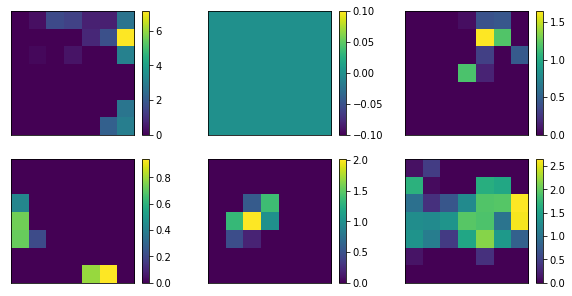

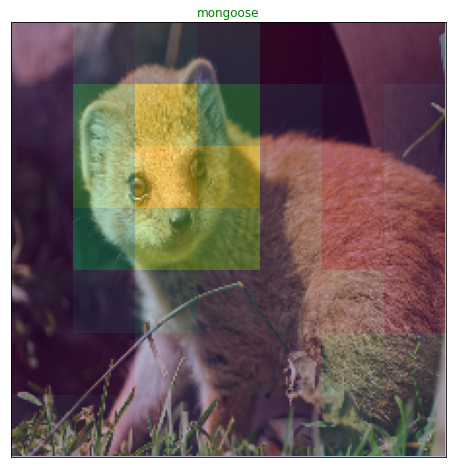

In [39]:
load_model.eval()
with torch.no_grad():
    X_feature = load_model.features(X)
    X_feature = load_model.avgpool(X_feature).cpu()

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1, xticks=[], yticks=[])
    plt.imshow(X_feature[0,i,:,:])
    plt.colorbar()

summed_map = X_feature.sum(dim=1)
plt.figure(figsize=(8,8))
plt.xticks([]); plt.yticks([])
plt.imshow(X[0,...].cpu().permute(1,2,0))
plt.imshow(summed_map[0,...], extent=[0,224,224,0], alpha=0.4)
pred_class = idx2label[pred_top5[0].item()]
plt.title(pred_class, color="g")